In [2]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from pymongo import *
from mpl_toolkits.basemap import Basemap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

%matplotlib inline

# Bringing in Our Data  

We first need to bring in our given spray data so that we can perform a DBScan on it in order to determine clusters of sprays. This will allow us to attach a trap to a spray cluster based on geographic coordinates. This will then be added to our dataframe as a new feature to enhance our predictive power. This DBScan technique was formulated and tested out in the dbscan_prep.ipynb file in the repo. The tinkering was done in that file and then the finished product (best epsilon value, min_samples value) were brought over here to incorporate into our final model creation. 

In [3]:
# Import the spray data so that we can perform clustering analysis on it.
df = pd.read_csv('https://raw.githubusercontent.com/cl65610/west_nile/master/assets/spray.csv')

In [4]:
df.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [5]:
# Set our features for this clustering. 
X = df[['Longitude', 'Latitude']]

In [6]:
# After much tinkering, these parameters gave us what appeared to be an ideal number of groups
dbscn = DBSCAN(eps = .0049, min_samples = 80).fit(X)  
labels = dbscn.labels_

In [7]:
print 'This DBSCAN results in the creation of %d different labels.' % len(set(labels))

This DBSCAN results in the creation of 15 different labels.


In [8]:
# We will now treat these labels as a new feature of our data. Attaching them to our original dataframe will allow us to 
# plot them and visualize our accuracy.
labels_df = pd.DataFrame(labels.reshape(14835,1), columns = ['labels'])

In [9]:
# This merged dataframe is also the dataframe that we'll send up to sql to be joined on. 
merged_df = df.join(labels_df)
merged_df.head()

,Date,Time,Latitude,Longitude,labels
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,0
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,0
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,0
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,0
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,0


In [10]:
X = merged_df[['Latitude', 'Longitude']]
y = merged_df['labels']

In [11]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc_fit = etc.fit(X, y)
print 'The score for our Extra Trees model is %.5f.' % etc.score(X, y)

The score for our Extra Trees model is 1.00000.


In [12]:
# In order to test our accuracy, we will import our train data, apply the fit, and check visually to see how well our
# classifier performs.
train_df = pd.read_csv('https://raw.githubusercontent.com/cl65610/west_nile/master/assets/joined_pca.csv')

In [13]:
# As above, our features for this will be latitude and longitude. 
X2 = train_df[['Latitude', 'Longitude']]

In [14]:
# Here we predict what our train data spray zones will be and set those results equal to a dataframe that we can then join 
# onto our training data.
label_predicts = etc_fit.predict(X2)
xt_labels = pd.DataFrame(label_predicts, columns = ['xt_labels'])

In [15]:
labeled_df = train_df.join(xt_labels)

In [16]:
print labeled_df.shape
labeled_df.head()

(10506, 27)


,Unnamed: 0,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day,...,PrecipTotal,Sunrise,Sunset,month_weather,day_weather,pca1,pca2,pca3,pca4,xt_labels
0,0,2007-05-29,2,1,41.954690,-87.800991,9,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,7
1,1,2007-05-29,3,1,41.954690,-87.800991,9,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,7
2,2,2007-05-29,3,6,41.994991,-87.769279,9,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,2
3,3,2007-05-29,2,13,41.974089,-87.824812,8,1,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,1
4,4,2007-05-29,3,13,41.974089,-87.824812,8,4,0,179,...,0.0,421.0,1917.0,5.0,179.0,-0.663872,3.033573,-1.434144,1.092123,1


You can see in the dataframe head above that the final column, named xt_labels, is whichever spray cluster a trap was closest to according to our DBScan and Extra Trees Classifier. The value counts for the spray clusters can be seen below, with all -1 values being points not assigned to any cluster.

In [17]:
print labeled_df.xt_labels.value_counts()

-1     4964
 11     995
 3      972
 5      927
 7      646
 4      447
 13     399
 9      364
 1      354
 2      195
 12     116
 8      106
 10      21
Name: xt_labels, dtype: int64


# Modeling Phase  

We are now going to create a dataframe with all our desired feature columns coming from a combination of our original datasets, principal component analysis, and dbscan for spray zones.  

We will be fitting a variety of different models to the data and then will use a Voting Classifier to join together the outputs of the different models, weighting each of the estimators according to its predictive power for this particular situation. These weights were determined by conceptual problem solving combined with trial and error.

In [157]:
features = ['Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy', 'day_weather', 'PrecipTotal', 
           'pca1', 'pca2', 'pca3', 'pca4', 'xt_labels', 'year']

X = labeled_df[features]
y = labeled_df.WnvPresent

In [158]:
## this is the dataframe will will be building all our models off of, exporting to csv

labeled_df.to_csv('model_building_df.csv')

In [159]:
X = pd.DataFrame(X, columns = features)
X.head()

,Species,Trap,Latitude,Longitude,AddressAccuracy,day_weather,PrecipTotal,pca1,pca2,pca3,pca4,xt_labels,year
0,2,1,41.954690,-87.800991,9,179.0,0.0,-0.663872,3.033573,-1.434144,1.092123,7,2007
1,3,1,41.954690,-87.800991,9,179.0,0.0,-0.663872,3.033573,-1.434144,1.092123,7,2007
2,3,6,41.994991,-87.769279,9,179.0,0.0,-0.663872,3.033573,-1.434144,1.092123,2,2007
3,2,13,41.974089,-87.824812,8,179.0,0.0,-0.663872,3.033573,-1.434144,1.092123,1,2007
4,3,13,41.974089,-87.824812,8,179.0,0.0,-0.663872,3.033573,-1.434144,1.092123,1,2007


In [160]:
knn = KNeighborsClassifier()
lr = LogisticRegression(penalty = 'l2', random_state = 42)
svm = SVC(probability = True, random_state = 42)
rf = RandomForestClassifier(random_state = 42)
etc = ExtraTreesClassifier(random_state = 42)
gbc = GradientBoostingClassifier(random_state = 42)
bc = BaggingClassifier(lr, random_state = 42)
ada = AdaBoostClassifier(random_state = 42)

### Model Testing  

We conducted trials with different combinations of the estimators instantiated above and found the combination of estimators and associated weights plugged into the voting classifier below consistently lead to the highest AUC when tested. 

In [162]:
from sklearn.ensemble import VotingClassifier

voter = VotingClassifier(estimators = [('knn', knn),
                                       ('lr', lr),
                                       ('extra trees', etc),
                                       ('random forest', rf),
                                       ('svm', svm),
                                       ('gbc', gbc),
                                       #('ada', ada),
                                       #('bc', bc)
                                      ],
                        voting = 'soft', weights = [1, 1, 3, 1, 1, 2])

voter_fit = voter.fit(X, y)
print voter.score(X, y)

predicts = voter.predict_proba(X)
pred_proba = predicts[:,1]


0.966685703408


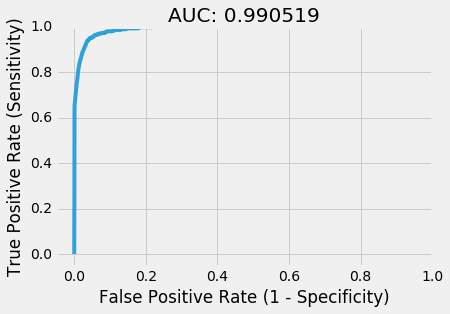

In [163]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = metrics.roc_curve(y, pred_proba)

plt.style.use('fivethirtyeight')

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label="Voting Classifier")
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('AUC: %f' % auc)

plt.show()

# Predictions on Test Data  

Our feature engineering and model construction stage is now complete, we simply need to bring in the test dataset and create our predictions.

We conducted PCA on the test dataset and added those features as columns in the link below:

[PCA for Test Data](https://github.com/cl65610/west_nile/blob/master/research/PCA_prep.ipynb "Test_Data_PCA")  

We already have our DBScan fit to our spray data from above, so all we needed to do was plug in the coordinates of the traps in the test data to get cluster predictions, which were then attached to our dataframe as a feature.

Finally, we simply plugged in our feature space from our dataframe into the already-fit voting classifier to attain the predict-proba values. These values were formed into a dataframe, saved as a csv, and sent to the Kaggle website for a score.

In [165]:
final_joined_pca = pd.read_csv('/Users/TerryONeill/west_nile/west_nile/assets/final_joined_pca.csv')
print final_joined_pca.shape
final_joined_pca.head()

(116293, 24)


,Unnamed: 0,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,day,month,year,...,DewPoint,PrecipTotal,Sunrise,Sunset,month_weather,day_weather,pca1,pca2,pca3,pca4
0,0,2008-06-11,2,1,41.95469,-87.800991,9,191,6,2008,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
1,1,2008-06-11,3,1,41.95469,-87.800991,9,191,6,2008,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
2,2,2008-06-11,1,1,41.95469,-87.800991,9,191,6,2008,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
3,3,2008-06-11,4,1,41.95469,-87.800991,9,191,6,2008,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
4,4,2008-06-11,6,1,41.95469,-87.800991,9,191,6,2008,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445


In [166]:
## need to drop unnamed column that forms from the index of the original dataframe
final_joined_pca = final_joined_pca.drop('Unnamed: 0', axis = 1)
print final_joined_pca.shape
final_joined_pca.head()

(116293, 23)


,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,day,month,year,Tmax,...,DewPoint,PrecipTotal,Sunrise,Sunset,month_weather,day_weather,pca1,pca2,pca3,pca4
0,2008-06-11,2,1,41.95469,-87.800991,9,191,6,2008,86.0,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
1,2008-06-11,3,1,41.95469,-87.800991,9,191,6,2008,86.0,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
2,2008-06-11,1,1,41.95469,-87.800991,9,191,6,2008,86.0,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
3,2008-06-11,4,1,41.95469,-87.800991,9,191,6,2008,86.0,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445
4,2008-06-11,6,1,41.95469,-87.800991,9,191,6,2008,86.0,...,55.5,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445


In [167]:
# As above, our features for this will be latitude and longitude. 
X2 = final_joined_pca[['Latitude', 'Longitude']]

In [168]:
# Here we predict what our test data spray zones will be and set those results equal to a dataframe that we can then join 
# onto our joined_pca data.



label_predicts = etc_fit.predict(X2)
xt_labels = pd.DataFrame(label_predicts, columns = ['xt_labels'])
print xt_labels.shape
xt_labels.head()

(116293, 1)


,xt_labels
0,7
1,7
2,7
3,7
4,7


In [169]:
labeled_df = final_joined_pca.join(xt_labels)

In [170]:
print labeled_df.shape
labeled_df.head()

(116293, 24)


,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,day,month,year,Tmax,...,PrecipTotal,Sunrise,Sunset,month_weather,day_weather,pca1,pca2,pca3,pca4,xt_labels
0,2008-06-11,2,1,41.95469,-87.800991,9,191,6,2008,86.0,...,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445,7
1,2008-06-11,3,1,41.95469,-87.800991,9,191,6,2008,86.0,...,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445,7
2,2008-06-11,1,1,41.95469,-87.800991,9,191,6,2008,86.0,...,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445,7
3,2008-06-11,4,1,41.95469,-87.800991,9,191,6,2008,86.0,...,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445,7
4,2008-06-11,6,1,41.95469,-87.800991,9,191,6,2008,86.0,...,0.0,416.0,1926.0,6.0,191.0,-1.514379,-1.779891,-0.967131,0.524445,7


In [171]:
features = ['Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy', 'day_weather', 'PrecipTotal', 
           'pca1', 'pca2', 'pca3', 'pca4', 'xt_labels', 'year']


X = labeled_df[features]


In [172]:
test_pred_proba = voter_fit.predict_proba(X)

In [173]:
test_proba_df = pd.DataFrame(test_pred_proba, columns = ['prob_0', 'prob_1'])
test_proba_df.head()

,prob_0,prob_1
0,0.838264,0.161736
1,0.977552,0.022448
2,0.958411,0.041589
3,0.980558,0.019442
4,0.980556,0.019444


In [174]:
test_proba_df['Id'] = range(1, 116294)
test_proba_df.set_index('Id', inplace = True)
test_proba_df.drop('prob_0', axis = 1, inplace = True)
test_proba_df.head()

,prob_1
Id,
1,0.161736
2,0.022448
3,0.041589
4,0.019442
5,0.019444


In [175]:
test_proba_df.columns = ['WnvPresent']
test_proba_df.head()

,WnvPresent
Id,
1,0.161736
2,0.022448
3,0.041589
4,0.019442
5,0.019444


In [176]:
test_proba_df.to_csv('test_data_predictions.csv')

# Submission  

The final dataframe in the cell above (test_proba_df) was saved as a csv and submitted to Kaggle for a score.  

Our best final score was .716, which was well above the benchmark score of 